# Exploring data augmentation methods

### Import libaries

In [1]:
# Common libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import torch

# Seed
SEED = 11
torch.manual_seed(SEED)

### Labels

In [12]:
labels = {
    0: "N",
    1: "S",
    2: "V",
    3: "F",
    4: "Q"
}

### Import dataset

In [7]:
train_data = pd.read_csv("Heartbeat_Dataset/mitbih_train.csv")
test_data = pd.read_csv("Heartbeat_Dataset/mitbih_test.csv")

train_data.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,4.411764815449714661e-02,6.127450987696647644e-02,6.617647409439086914e-02,6.127450987696647644e-02.1,4.901960864663124084e-02.1,7.352941483259201050e-02,6.127450987696647644e-02.2,6.127450987696647644e-02.3,6.617647409439086914e-02.1,6.862745434045791626e-02,9.558823704719543457e-02,7.598039507865905762e-02,9.313725680112838745e-02,1.053921580314636230e-01,1.151960790157318115e-01,1.029411777853965759e-01,1.176470592617988586e-01,1.250000000000000000e-01,1.421568691730499268e-01,1.274509876966476440e-01,1.519607901573181152e-01.1,1.446078419685363770e-01,1.642156839370727539e-01,1.446078419685363770e-01.1,1.593137234449386597e-01,1.519607901573181152e-01.2,1.544117629528045654e-01.1,1.421568691730499268e-01.1,1.519607901573181152e-01.3,1.519607901573181152e-01.4,...,0.000000000000000000e+00.49,0.000000000000000000e+00.50,0.000000000000000000e+00.51,0.000000000000000000e+00.52,0.000000000000000000e+00.53,0.000000000000000000e+00.54,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65,0.000000000000000000e+00.66,0.000000000000000000e+00.67,0.000000000000000000e+00.68,0.000000000000000000e+00.69,0.000000000000000000e+00.70,0.000000000000000000e+00.71,0.000000000000000000e+00.72,0.000000000000000000e+00.73,0.000000000000000000e+00.74,0.000000000000000000e+00.75,0.000000000000000000e+00.76,0.000000000000000000e+00.77,0.000000000000000000e+00.78,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0

Column names are not provided in csv file, hence we will set header parameter to None below to obtain the the correct train and test datasets

In [8]:
train_data = pd.read_csv("Heartbeat_Dataset/mitbih_train.csv", header=None)
test_data = pd.read_csv("Heartbeat_Dataset/mitbih_test.csv", header=None)

train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split train dataset into train and validation sets before performing data augmentation

In [9]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # Exclude label
y_train = train_data.iloc[:, -1].values   # Labels

# Stratifying the split so both train and validation sets have same class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

### View data distribution

In [13]:
# Check number of samples in datasets
print(f"Number of samples in train data: {X_train.shape[0]}")

# Check distribution of classes in test and train sets
classes, counts = np.unique(y_train, return_counts=True)
class_labels = np.vectorize(labels.get)(classes) # convert to their string labels

# print the counts
print(np.asarray((class_labels, counts)).T)

Number of samples in train data: 70043
[['N' '57977']
 ['S' '1778']
 ['V' '4630']
 ['F' '513']
 ['Q' '5145']]


C:\Users\User\AppData\Local\Temp\ipykernel_23588\832063077.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.barplot(x=class_labels, y=counts, palette=colors)
C:\Users\User\AppData\Local\Temp\ipykernel_23588\832063077.py:4: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sb.barplot(x=class_labels, y=counts, palette=colors)


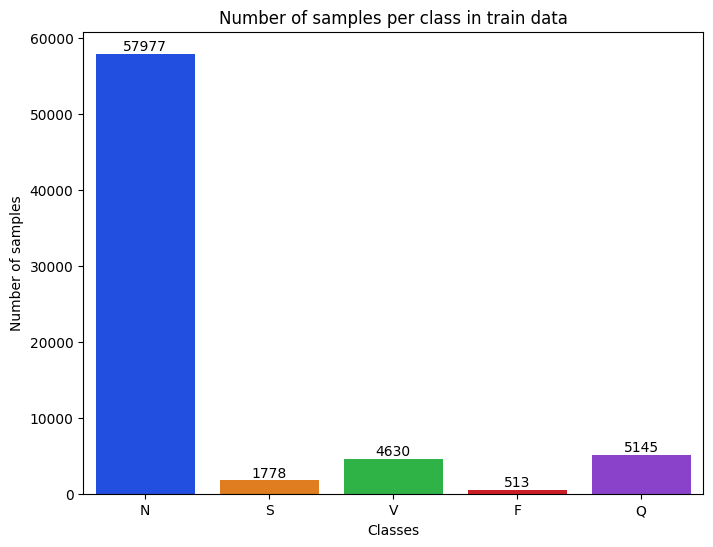

In [16]:
colors = sb.color_palette('bright')

plt.figure(figsize=(8, 6))
ax = sb.barplot(x=class_labels, y=counts, palette=colors)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of samples per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

Text(0.5, 1.0, 'Percentage of each class in train data')

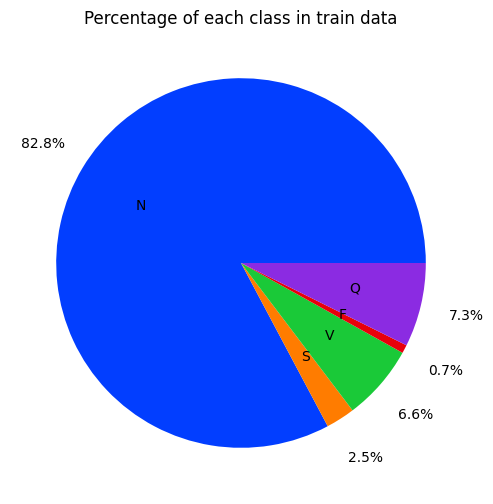

In [15]:
plt.figure(figsize=(8, 6))
plt.pie(x=counts, labels=class_labels, colors=colors,
        autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)
plt.title('Percentage of each class in train data')

As can be seen, the distribution of the data is very imbalanced with class N having significantly more data points compared to the other classes, this could result in training a biased model towards the majority class, N in this case. The models trained from the imbalanced data may not generalise well to new, unseen data especially for the minority classes.

## Synthetic Minority Over-Sampling Technique (SMOTE)

### Resample data using SMOTE

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Data distribution

[['N' '57977']
 ['S' '57977']
 ['V' '57977']
 ['F' '57977']
 ['Q' '57977']]


Text(0.5, 1.0, 'Percentage of each class in resampled train data')

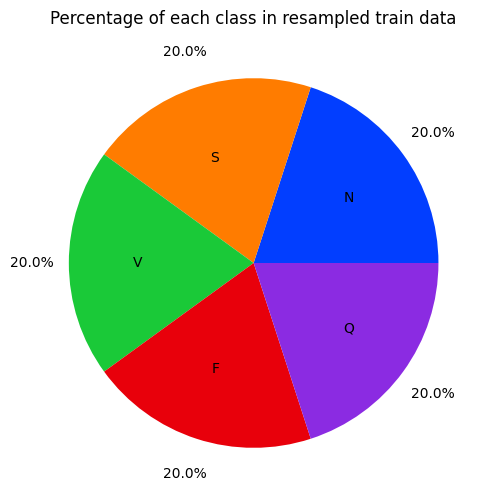

In [21]:
classes, counts = np.unique(y_train_resampled, return_counts=True)
class_labels = np.vectorize(labels.get)(classes) # convert to their string labels

# print the counts
print(np.asarray((class_labels, counts)).T)

plt.figure(figsize=(8, 6))
plt.pie(x=counts, labels=class_labels, colors=colors,
        autopct='%1.1f%%', pctdistance=1.2, labeldistance=.6)
plt.title('Percentage of each class in resampled train data')

By using SMOTE, we sampled the minority classes (S, V, Q and F) and generated more data for them in order to match the number of samples in the majority class N, to get a balanced dataset where all classes have the same number of samples.

## CTGANSynthesizer

In [ ]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import Metadata

In [ ]:
# Metadata required for synthesizer in sdv
metadata = Metadata.detect_from_dataframe(
    data=train_data,
    table_name='mitbih_train')

synthesizer = CTGANSynthesizer(metadata, verbose=True, cuda=True)
synthesizer.fit(data=train_data)

synthesizer.save(
    filepath='CTGANSynthesizer.pkl'
)

## GaussianCopulaSynthesizer

In [ ]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata

In [ ]:
# Metadata required for synthesizer in sdv
metadata = Metadata.detect_from_dataframe(
    data=train_data,
    table_name='mitbih_train')

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data=train_data)

synthesizer.save(
    filepath='GaussianCopulaSynthesizer.pkl'
)

### Generate synthetic data

In [ ]:
synthetic_train_data = synthesizer.sample(num_rows=100_000, batch_size=1000)

### Evaluating real vs synthetic data

In [ ]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_train_data,
    metadata=metadata
)

## Class weighting

While class weighting is not a data augmentation method, it can help to alleviate the problem of an imbalanced dataset

In [ ]:
from sklearn.utils import compute_class_weight

In [ ]:
# Separate features and labels
train_counts = train_data.iloc[:,-1].value_counts().rename(labels)

class_weights = compute_class_weight("balanced", classes=train_counts.index, y=train_counts.values)

# Set weights for each class in loss function
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))